In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg-data/vgg16_bn-6c64b313.pth
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_309.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_89.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_98.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_236.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_172.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_142.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_53.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_273.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_271.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_94.mat
/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_25.mat
/kaggle/input/shanghaitec

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio


In [3]:
base = "/kaggle/input/shanghaitech/ShanghaiTech"

partA_train_img = base + "/part_A/train_data/images"
partA_train_gt  = base + "/part_A/train_data/ground-truth"

print("Images:", len(os.listdir(partA_train_img)))
print("Ground truth files:", len(os.listdir(partA_train_gt)))


Images: 300
Ground truth files: 300


In [4]:
img_paths = sorted(glob.glob(os.path.join(partA_train_img, "*.jpg")))
sample_img_path = img_paths[265]     # first image
sample_img_path


'/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_68.jpg'

In [5]:
img = Image.open(sample_img_path).convert('RGB')
img_np = np.array(img)

basename = os.path.basename(sample_img_path).replace(".jpg", "")
mat_path = os.path.join(partA_train_gt, "GT_" + basename + ".mat")
mat = sio.loadmat(mat_path)

# Extract points (x, y)
points = mat["image_info"][0][0][0][0][0]   # MATLAB's annoying nested indexing
points = np.array(points)
print("Number of head annotations:", len(points))


Number of head annotations: 199


In [6]:
img = Image.open(sample_img_path).convert('RGB')
img_np = np.array(img)

basename = os.path.basename(sample_img_path).replace(".jpg", "")
mat_path = os.path.join(partA_train_gt, "GT_" + basename + ".mat")
mat = sio.loadmat(mat_path)

# Extract points (x, y)
points = mat["image_info"][0][0][0][0][0]   # MATLAB's annoying nested indexing
points = np.array(points)
print("Number of head annotations:", len(points))


Number of head annotations: 199


In [7]:
from scipy.ndimage import gaussian_filter

H, W = img_np.shape[:2]
density = np.zeros((H, W), dtype=np.float32)

for x, y in points:
    x = min(W - 1, max(0, int(x)))
    y = min(H - 1, max(0, int(y)))
    density[y, x] += 1

density = gaussian_filter(density, sigma=4)   # sigma=4 is standard for ShanghaiTech
print("Density sum (crowd count):", density.sum())


Density sum (crowd count): 199.0


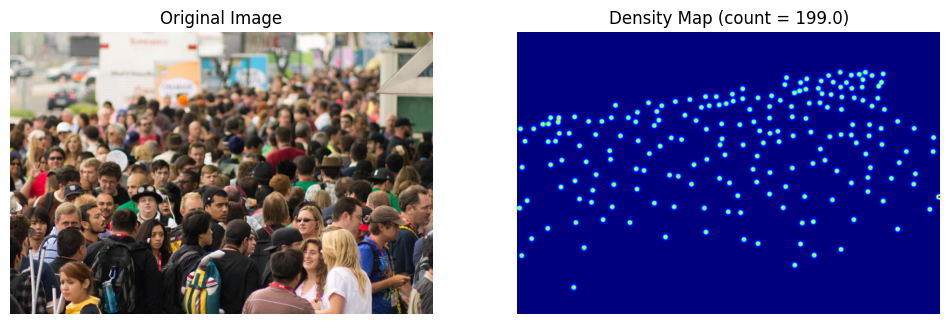

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(density, cmap='jet')
plt.title(f"Density Map (count = {density.sum():.1f})")
plt.axis("off")

plt.show()


In [9]:
save_dir = "/kaggle/working/partA_train_density"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, basename + ".npy"), density)


In [10]:
crowd_count = density.sum()
print("Crowd count:", crowd_count)


Crowd count: 199.0


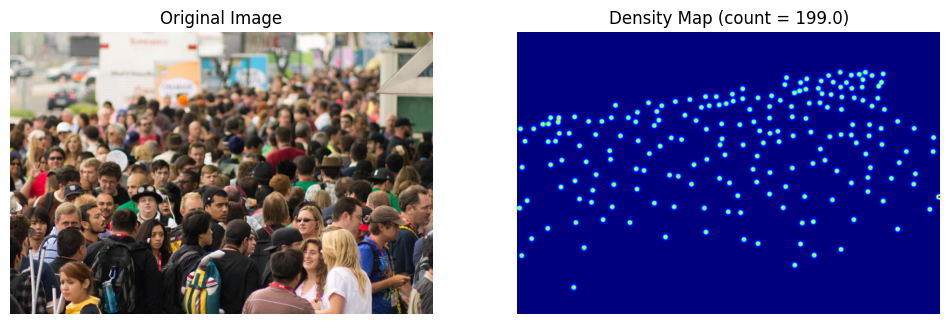

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(density, cmap='jet')
plt.title(f"Density Map (count = {crowd_count:.1f})")
plt.axis("off")

plt.show()


In [12]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import scipy.io as sio
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [13]:
base = "/kaggle/input/shanghaitech"

# auto-detect Part A folders
partA_train_img = glob.glob(os.path.join(base, "**", "part_A*", "train_data", "images"), recursive=True)[0]
partA_train_gt  = glob.glob(os.path.join(base, "**", "part_A*", "train_data", "ground*"), recursive=True)[0]

partA_test_img  = glob.glob(os.path.join(base, "**", "part_A*", "test_data", "images"), recursive=True)[0]
partA_test_gt   = glob.glob(os.path.join(base, "**", "part_A*", "test_data", "ground*"), recursive=True)[0]

print("Train img dir :", partA_train_img)
print("Train gt dir  :", partA_train_gt)
print("Test  img dir :", partA_test_img)
print("Test  gt dir  :", partA_test_gt)

print("Train JPG count:", len(glob.glob(os.path.join(partA_train_img, "*.jpg"))))
print("Test  JPG count:", len(glob.glob(os.path.join(partA_test_img, "*.jpg"))))


Train img dir : /kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images
Train gt dir  : /kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth
Test  img dir : /kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images
Test  gt dir  : /kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth
Train JPG count: 300
Test  JPG count: 182


In [14]:
out_train_density = "/kaggle/working/partA_train_density"
out_test_density  = "/kaggle/working/partA_test_density"
os.makedirs(out_train_density, exist_ok=True)
os.makedirs(out_test_density, exist_ok=True)

def generate_density_map(img_shape, points, sigma=4):
    H, W = img_shape
    density = np.zeros((H, W), dtype=np.float32)
    if len(points) == 0:
        return density

    for x, y in points:
        x = min(W - 1, max(0, int(x)))
        y = min(H - 1, max(0, int(y)))
        density[y, x] += 1

    density = gaussian_filter(density, sigma=sigma)
    return density

def process_split(img_dir, gt_dir, out_dir):
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    print(f"Processing {len(img_paths)} images in {img_dir}")
    for img_path in img_paths:
        basename = os.path.basename(img_path).replace(".jpg", "")
        out_path = os.path.join(out_dir, basename + ".npy")
        if os.path.exists(out_path):
            continue

        img = Image.open(img_path).convert('RGB')
        img_np = np.array(img)
        H, W = img_np.shape[:2]

        mat_path = os.path.join(gt_dir, "GT_" + basename + ".mat")
        mat = sio.loadmat(mat_path)

        # extract (x,y) points
        points = mat["image_info"][0][0][0][0][0]
        points = np.array(points)

        density = generate_density_map((H, W), points, sigma=4)
        np.save(out_path, density)
    print("Done:", out_dir)

process_split(partA_train_img, partA_train_gt, out_train_density)
process_split(partA_test_img,  partA_test_gt,  out_test_density)


Processing 300 images in /kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images
Done: /kaggle/working/partA_train_density
Processing 182 images in /kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images
Done: /kaggle/working/partA_test_density


In [15]:
class ShanghaiTechPartA(Dataset):
    def __init__(self, img_dir, density_dir, transform=None):
        self.img_dir = img_dir
        self.density_dir = density_dir
        self.transform = transform

        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        basename = os.path.basename(img_path).replace(".jpg", "")

        # image
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()(img)

        # density
        density_path = os.path.join(self.density_dir, basename + ".npy")
        density = np.load(density_path).astype(np.float32)

        # IMPORTANT: create new storage tensor (not from_numpy shared)
        density_t = torch.tensor(density, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

        count = density_t.sum()

        return img_t, density_t, count


In [16]:
class MCNN(nn.Module):
    def __init__(self):
        super().__init__()

        def make_branch(ks):
            return nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=ks, padding=ks//2),
                nn.ReLU(inplace=True),
                nn.Conv2d(16, 32, kernel_size=ks, padding=ks//2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 16, kernel_size=ks, padding=ks//2),
                nn.ReLU(inplace=True),
                nn.Conv2d(16, 8, kernel_size=ks, padding=ks//2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            )

        self.branch1 = make_branch(9)
        self.branch2 = make_branch(7)
        self.branch3 = make_branch(5)

        # NOTE: no ReLU here – output is raw density
        self.fuse = nn.Conv2d(8 * 3, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat((x1, x2, x3), dim=1)
        out = self.fuse(x_cat)
        return out


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

transform = transforms.Compose([
    transforms.Resize((480, 640)),   # fixed input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ShanghaiTechPartA(
    img_dir=partA_train_img,
    density_dir=out_train_density,
    transform=transform
)

test_dataset = ShanghaiTechPartA(
    img_dir=partA_test_img,
    density_dir=out_test_density,
    transform=transform
)

print("Train len:", len(train_dataset))
print("Test  len:", len(test_dataset))

# robust settings: batch_size=1, num_workers=0
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=0)


Device: cuda
Train len: 300
Test  len: 182


In [18]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    total_loss = 0.0

    for imgs, densities, _ in loader:
        imgs = imgs.to(device)
        densities = densities.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  # (B,1,h_out,w_out)

        # resize GT density to match output spatial size
        if outputs.shape[-2:] != densities.shape[-2:]:
            densities_resized = F.interpolate(
                densities,
                size=outputs.shape[-2:],
                mode='bilinear',
                align_corners=False
            )
        else:
            densities_resized = densities

        loss = criterion(outputs, densities_resized)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    mae = 0.0
    mse = 0.0
    n = 0

    for imgs, densities, _ in loader:
        imgs = imgs.to(device)
        densities = densities.to(device)

        preds = model(imgs)

        # predicted count from output density
        pred_counts = preds.sum(dim=[1, 2, 3]).cpu()

        # GT count from original density
        gt_counts   = densities.sum(dim=[1, 2, 3]).cpu()

        diff = pred_counts - gt_counts
        mae += diff.abs().sum().item()
        mse += (diff ** 2).sum().item()
        n += imgs.size(0)

    mae /= n
    rmse = (mse / n) ** 0.5
    return mae, rmse


In [19]:
model = MCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50  # adjust as you like
history = {"train_loss": [], "mae": [], "rmse": []}

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    mae, rmse = evaluate(model, test_loader, device)

    history["train_loss"].append(train_loss)
    history["mae"].append(mae)
    history["rmse"].append(rmse)

    print(f"Epoch {epoch:03d}: loss={train_loss:.6f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

torch.save(model.state_dict(), "/kaggle/working/mcnn_partA.pth")
print("Model saved to /kaggle/working/mcnn_partA.pth")


Epoch 001: loss=0.001879, MAE=662.74, RMSE=766.10
Epoch 002: loss=0.000497, MAE=601.31, RMSE=695.30
Epoch 003: loss=0.000141, MAE=282.03, RMSE=434.06
Epoch 004: loss=0.000096, MAE=298.97, RMSE=445.22
Epoch 005: loss=0.000075, MAE=479.30, RMSE=586.86
Epoch 006: loss=0.000050, MAE=558.04, RMSE=655.50
Epoch 007: loss=0.000044, MAE=610.53, RMSE=701.62
Epoch 008: loss=0.000037, MAE=407.91, RMSE=535.12
Epoch 009: loss=0.000037, MAE=600.37, RMSE=689.96
Epoch 010: loss=0.000033, MAE=475.56, RMSE=586.87
Epoch 011: loss=0.000025, MAE=440.28, RMSE=561.46
Epoch 012: loss=0.000032, MAE=363.48, RMSE=498.03
Epoch 013: loss=0.000028, MAE=479.96, RMSE=592.70
Epoch 014: loss=0.000026, MAE=352.99, RMSE=491.72
Epoch 015: loss=0.000022, MAE=363.22, RMSE=501.77
Epoch 016: loss=0.000018, MAE=424.09, RMSE=547.02
Epoch 017: loss=0.000025, MAE=376.93, RMSE=512.60
Epoch 018: loss=0.000019, MAE=377.38, RMSE=511.30
Epoch 019: loss=0.000018, MAE=317.86, RMSE=469.57
Epoch 020: loss=0.000019, MAE=402.29, RMSE=531.16


GT count   : 172.00
Pred count : 33.93


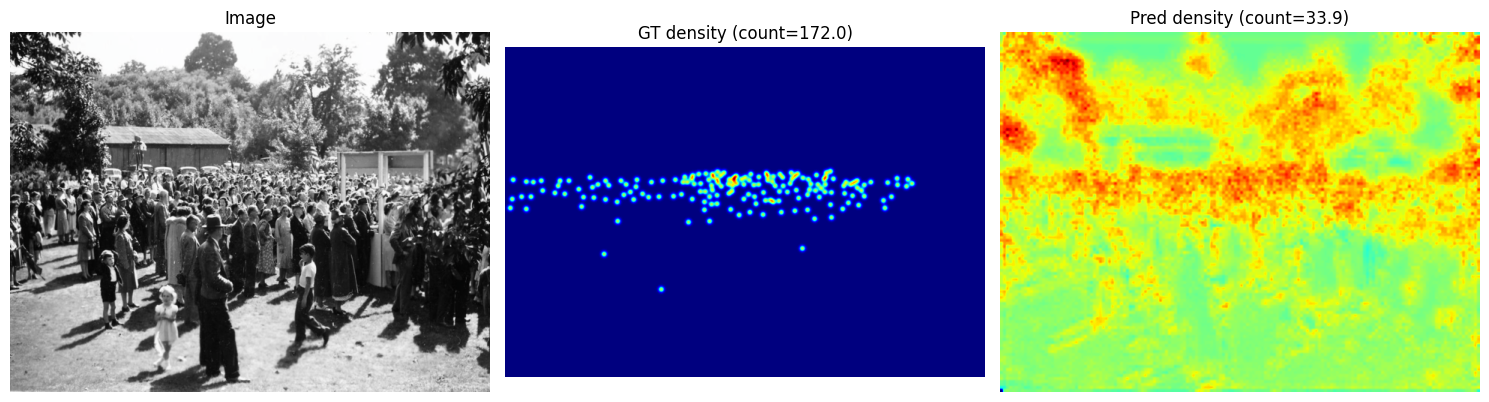

In [20]:
# one sample from test set
imgs, dens, _ = next(iter(test_loader))

model.eval()
with torch.no_grad():
    preds = model(imgs.to(device))

gt_count   = dens.sum().item()
pred_count = preds.sum().item()

print(f"GT count   : {gt_count:.2f}")
print(f"Pred count : {pred_count:.2f}")

# prepare for plotting
img_np = imgs[0].permute(1, 2, 0).cpu().numpy()
img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
img_np = img_np.clip(0, 1)

gt_den   = dens[0, 0].cpu().numpy()
pred_den = preds[0, 0].cpu().numpy()

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_den, cmap='jet')
plt.title(f"GT density (count={gt_count:.1f})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_den, cmap='jet')
plt.title(f"Pred density (count={pred_count:.1f})")
plt.axis("off")

plt.tight_layout()
plt.show()


In [27]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import scipy.io as sio
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


In [28]:
# ShanghaiTech base
base = "/kaggle/input/shanghaitech"

# auto-detect Part_A paths
partA_train_img = glob.glob(os.path.join(base, "**", "part_A*", "train_data", "images"), recursive=True)[0]
partA_train_gt  = glob.glob(os.path.join(base, "**", "part_A*", "train_data", "ground*"), recursive=True)[0]

partA_test_img  = glob.glob(os.path.join(base, "**", "part_A*", "test_data", "images"), recursive=True)[0]
partA_test_gt   = glob.glob(os.path.join(base, "**", "part_A*", "test_data", "ground*"), recursive=True)[0]

print("Train img dir :", partA_train_img)
print("Train gt dir  :", partA_train_gt)
print("Test  img dir :", partA_test_img)
print("Test  gt dir  :", partA_test_gt)
print("Train JPG count:", len(glob.glob(os.path.join(partA_train_img, '*.jpg'))))
print("Test  JPG count :", len(glob.glob(os.path.join(partA_test_img, '*.jpg'))))

# your uploaded VGG16_bn weights
vgg_path = "/kaggle/input/vgg-data/vgg16_bn-6c64b313.pth"
assert os.path.exists(vgg_path), "vgg16_bn-6c64b313.pth not found at /kaggle/input/vgg-data/"
print("VGG weights path:", vgg_path)


Train img dir : /kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images
Train gt dir  : /kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth
Test  img dir : /kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images
Test  gt dir  : /kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth
Train JPG count: 300
Test  JPG count : 182
VGG weights path: /kaggle/input/vgg-data/vgg16_bn-6c64b313.pth


In [29]:
out_train_density = "/kaggle/working/partA_train_density"
out_test_density  = "/kaggle/working/partA_test_density"
os.makedirs(out_train_density, exist_ok=True)
os.makedirs(out_test_density, exist_ok=True)

def generate_density_map(img_shape, points, sigma=4):
    H, W = img_shape
    density = np.zeros((H, W), dtype=np.float32)
    if len(points) == 0:
        return density
    for x, y in points:
        x = min(W - 1, max(0, int(x)))
        y = min(H - 1, max(0, int(y)))
        density[y, x] += 1
    density = gaussian_filter(density, sigma=sigma)
    return density

def process_split(img_dir, gt_dir, out_dir):
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    print(f"Processing {len(img_paths)} images in {img_dir}")
    for img_path in img_paths:
        basename = os.path.basename(img_path).replace(".jpg", "")
        out_path = os.path.join(out_dir, basename + ".npy")
        if os.path.exists(out_path):
            continue

        img = Image.open(img_path).convert('RGB')
        img_np = np.array(img)
        H, W = img_np.shape[:2]

        mat_path = os.path.join(gt_dir, "GT_" + basename + ".mat")
        mat = sio.loadmat(mat_path)
        points = mat["image_info"][0][0][0][0][0]
        points = np.array(points)

        density = generate_density_map((H, W), points, sigma=4)
        np.save(out_path, density)
    print("Done:", out_dir)

process_split(partA_train_img, partA_train_gt, out_train_density)
process_split(partA_test_img,  partA_test_gt,  out_test_density)


Processing 300 images in /kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images
Done: /kaggle/working/partA_train_density
Processing 182 images in /kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images
Done: /kaggle/working/partA_test_density


In [30]:
class ShanghaiTechPartA(Dataset):
    def __init__(self, img_dir, density_dir, transform=None):
        self.img_dir = img_dir
        self.density_dir = density_dir
        self.transform = transform
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        basename = os.path.basename(img_path).replace(".jpg", "")

        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()(img)

        density_path = os.path.join(self.density_dir, basename + ".npy")
        density = np.load(density_path).astype(np.float32)
        density_t = torch.tensor(density, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

        count = density_t.sum()
        return img_t, density_t, count


In [31]:
class CSRNet(nn.Module):
    def __init__(self, vgg_weight_path: str):
        super().__init__()

        # Load VGG16_bn with your offline weights
        vgg = models.vgg16_bn()
        vgg.load_state_dict(torch.load(vgg_weight_path, map_location="cpu"))
        features = list(vgg.features.children())

        # VGG frontend (conv1_1 to conv4_3)
        self.frontend = nn.Sequential(*features[:33])

        # Dilated backend (CSRNet)
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        # 1-channel density output (no ReLU)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ShanghaiTechPartA(
    img_dir=partA_train_img,
    density_dir=out_train_density,
    transform=transform
)

test_dataset = ShanghaiTechPartA(
    img_dir=partA_test_img,
    density_dir=out_test_density,
    transform=transform
)

print("Train len:", len(train_dataset))
print("Test  len:", len(test_dataset))

# batch_size=1 avoids size issues
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=0)


Device: cuda
Train len: 300
Test  len: 182


In [33]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    total_loss = 0.0

    for imgs, densities, _ in loader:
        imgs = imgs.to(device)
        densities = densities.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        # resize GT density to match output spatial size
        if outputs.shape[-2:] != densities.shape[-2:]:
            densities_resized = F.interpolate(
                densities,
                size=outputs.shape[-2:],
                mode='bilinear',
                align_corners=False
            )
        else:
            densities_resized = densities

        loss = criterion(outputs, densities_resized)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    mae = 0.0
    mse = 0.0
    n = 0

    for imgs, densities, _ in loader:
        imgs = imgs.to(device)
        densities = densities.to(device)

        preds = model(imgs)

        pred_counts = preds.sum(dim=[1, 2, 3]).cpu()
        gt_counts   = densities.sum(dim=[1, 2, 3]).cpu()

        diff = pred_counts - gt_counts
        mae += diff.abs().sum().item()
        mse += (diff ** 2).sum().item()
        n += imgs.size(0)

    mae /= n
    rmse = (mse / n) ** 0.5
    return mae, rmse


In [35]:
model_csr = CSRNet(vgg_weight_path=vgg_path).to(device)
optimizer_csr = torch.optim.Adam(model_csr.parameters(), lr=1e-5)

num_epochs = 50   # you can later increase to 50
history_csr = {"train_loss": [], "mae": [], "rmse": []}

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model_csr, train_loader, optimizer_csr, device)
    mae, rmse = evaluate(model_csr, test_loader, device)

    history_csr["train_loss"].append(train_loss)
    history_csr["mae"].append(mae)
    history_csr["rmse"].append(rmse)

    print(f"[CSRNet] Epoch {epoch:03d}: loss={train_loss:.6f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

torch.save(model_csr.state_dict(), "/kaggle/working/csrnet_partA_fromscratch.pth")
print("Saved CSRNet to /kaggle/working/csrnet_partA_fromscratch.pth")


[CSRNet] Epoch 001: loss=0.000822, MAE=375.43, RMSE=508.86
[CSRNet] Epoch 002: loss=0.000033, MAE=387.55, RMSE=517.50
[CSRNet] Epoch 003: loss=0.000023, MAE=405.87, RMSE=534.29
[CSRNet] Epoch 004: loss=0.000015, MAE=396.79, RMSE=527.86
[CSRNet] Epoch 005: loss=0.000012, MAE=413.57, RMSE=539.52
[CSRNet] Epoch 006: loss=0.000011, MAE=395.32, RMSE=524.86
[CSRNet] Epoch 007: loss=0.000010, MAE=406.92, RMSE=535.51
[CSRNet] Epoch 008: loss=0.000009, MAE=405.25, RMSE=533.53
[CSRNet] Epoch 009: loss=0.000008, MAE=412.31, RMSE=538.92
[CSRNet] Epoch 010: loss=0.000008, MAE=414.97, RMSE=541.71
[CSRNet] Epoch 011: loss=0.000008, MAE=396.51, RMSE=527.06
[CSRNet] Epoch 012: loss=0.000007, MAE=421.59, RMSE=548.51
[CSRNet] Epoch 013: loss=0.000007, MAE=409.06, RMSE=536.07
[CSRNet] Epoch 014: loss=0.000006, MAE=415.16, RMSE=541.20
[CSRNet] Epoch 015: loss=0.000006, MAE=399.70, RMSE=529.42
[CSRNet] Epoch 016: loss=0.000006, MAE=414.55, RMSE=540.76
[CSRNet] Epoch 017: loss=0.000005, MAE=409.43, RMSE=536.

CSRNet - GT count   : 172.00
CSRNet - Pred count : 77.34


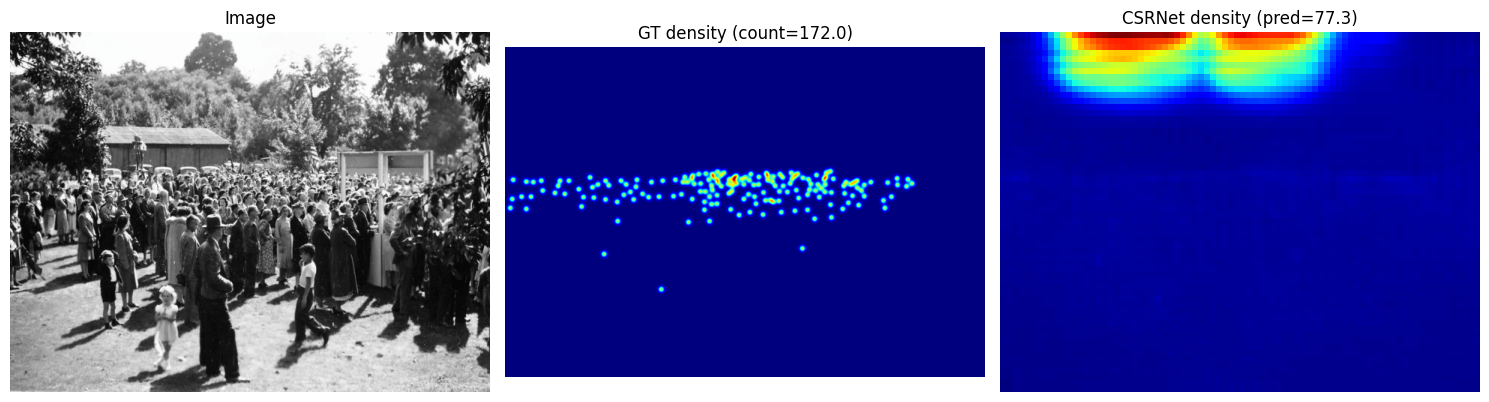

In [36]:
imgs, dens, _ = next(iter(test_loader))

model_csr.eval()
with torch.no_grad():
    preds = model_csr(imgs.to(device))

gt_count   = dens.sum().item()
pred_count = preds.sum().item()

print(f"CSRNet - GT count   : {gt_count:.2f}")
print(f"CSRNet - Pred count : {pred_count:.2f}")

img_np = imgs[0].permute(1, 2, 0).cpu().numpy()
img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
img_np = img_np.clip(0, 1)

gt_den   = dens[0, 0].cpu().numpy()
pred_den = preds[0, 0].cpu().numpy()

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_den, cmap='jet')
plt.title(f"GT density (count={gt_count:.1f})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_den, cmap='jet')
plt.title(f"CSRNet density (pred={pred_count:.1f})")
plt.axis("off")

plt.tight_layout()
plt.show()


In [37]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

vgg_path = "/kaggle/input/vgg-data/vgg16_bn-6c64b313.pth"

class CSRNet(nn.Module):
    def __init__(self, vgg_weight_path: str):
        super().__init__()
        vgg = models.vgg16_bn()
        vgg.load_state_dict(torch.load(vgg_weight_path, map_location="cpu"))
        features = list(vgg.features.children())

        self.frontend = nn.Sequential(*features[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

# create model + load trained weights
model_csr = CSRNet(vgg_weight_path=vgg_path).to(device)
ckpt_path = "/kaggle/working/csrnet_partA_fromscratch.pth"
model_csr.load_state_dict(torch.load(ckpt_path, map_location=device))
model_csr.eval()
print("Loaded trained CSRNet.")


Device: cuda
Loaded trained CSRNet.


In [39]:
transform_infer = transforms.Compose([
    transforms.Resize((480, 640)),          # same as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [40]:
real_img_dir = "/kaggle/input/cctv-images"  # TODO: change to your folder

img_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    img_paths.extend(glob.glob(os.path.join(real_img_dir, ext)))
img_paths = sorted(img_paths)

print("Found", len(img_paths), "images in", real_img_dir)


Found 0 images in /kaggle/input/cctv-images


In [ ]:
import csv

output_csv = "/kaggle/working/csrnet_real_counts.csv"

rows = [("filename", "pred_count")]

for idx, img_path in enumerate(img_paths):
    img = Image.open(img_path).convert("RGB")
    img_t = transform_infer(img).unsqueeze(0).to(device)

    with torch.no_grad():
        den = model_csr(img_t)
        pred_count = den.sum().item()

    rows.append((os.path.basename(img_path), pred_count))

    if idx < 3:  # visualize first 3
        img_np = np.array(img)

        den_np = den[0, 0].cpu().numpy()
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(img_np)
        plt.title(f"Real Image #{idx}")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(den_np, cmap="jet")
        plt.title(f"Pred density (count={pred_count:.1f})")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# write CSV
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("Saved counts CSV to:", output_csv)
